# Text vectorisation: Turning Text into Features

More advanced forms of text analysis require that text documents are converted into numerical values or features. In this  section we will examine:

* different methods for representing a collection of texts as numbers
* the decisions we need to make when generating a particular representation as well as the kinds of insights each numerical representation can give us.

We will use tools from the Python libraries `scikit-learn` and `gensim` to perform some popular text vectorisation methods:
* Re-cap of N-grams (unigram and bi-gram) term friquency
* TF-IDF (Term Frequency–Inverse Document Frequency)
* Word embedding—Word2Vec

In [1]:
# Import libraries

! pip install gensim
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

import gensim
from gensim.models import Word2Vec

from matplotlib import pyplot as plt

## Turning text into n-grams features 
### Unigrams

Compute the friquency of word occurance using count vectoriser in `scikit-learn`  

### Toy example

In [2]:
# Text corpus

# Load the parsed news dataset 
corpus = pd.read_csv('sample_news_large_phrased.csv', index_col='index')

In [3]:
corpus.head(1)

,query,title,text,published,site,tokens
index,,,,,,
0,Hong Kong,Horrifying view of fires from space,Video Image Satellite images show insane view ...,2019-11-08T23:51:00.000+02:00,news.com.au,video|*|image|*|satellite|*|image|*|insane|*|v...


In [4]:
# Subset news stories about brexit
corpus_brexit = corpus[corpus['query']=='brexit']

corpus_toy=corpus_brexit.iloc[[7,22], [1]]

# Set the maximum width of columns
pd.options.display.max_colwidth = 200

corpus_toy.head(5)

,title
index,
132,Brexit news: Gina Miller unveils new Remainer plot to block Brexit in general election | UK | News | Express.co.uk
147,Brexit news: Labour pledge to continue ‘freedom of movement’ infuriates Leavers | UK | News | Express.co.uk


In [5]:
# Use CountVectorizer to tokenize a collection of text documents and convert it into a matrix of token counts

# Create an instance of the CountVectorizer class
vectorizer = CountVectorizer()

# Learn the vocabulary from the corpus using the toy corpus
vectorizer.fit(corpus_toy['title'])

# Transform documents to document-term matrix
vector = vectorizer.transform(corpus_toy['title'])

# Print the tokens as a dictionary with tokens (keys) and integer feature indices (values) using the vocabulary_ attribute
print(vectorizer.vocabulary_)

{'brexit': 1, 'news': 16, 'gina': 8, 'miller': 13, 'unveils': 23, 'new': 15, 'remainer': 20, 'plot': 19, 'to': 21, 'block': 0, 'in': 9, 'general': 7, 'election': 4, 'uk': 22, 'express': 5, 'co': 2, 'labour': 11, 'pledge': 18, 'continue': 3, 'freedom': 6, 'of': 17, 'movement': 14, 'infuriates': 10, 'leavers': 12}


Note that punctuation and single letter's words are removed. We will use below the prerpocessed tokens you have already preprocessed.

In [6]:
# Access the feature index of a token
vectorizer.vocabulary_.get('brexit')

1

The numbers assigned to each token (e.g., "brexit") are indices. For clarity, indices are sorted in the cell bellow.

In [7]:
# Print the document-term matrix of rows (documents) and columns (count for the number of times a token appeared in the document) 
print(vector.toarray())

[[1 2 1 0 1 1 0 1 1 1 0 0 0 1 0 1 2 0 0 1 1 1 2 1]
 [0 1 1 1 0 1 1 0 0 0 1 1 1 0 1 0 2 1 1 0 0 1 2 0]]


`vector.toarray()` returns a matrix where the rows indicate the number of documents (two in our case) and the columns indicate the size of the vocabulary of the entire corpus (all documents).

Each document is encoded as a vector with a length indicating the size of the vocabulary of the entire corpus and an integer count for the number of times each token appeared in the document.

In [8]:
# Sort the dictionary of terms (keys) and indices (values) in the feature matrix by values in ascending order
print(dict(sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1])))

# Print the document-term matrix
print(vector.toarray())

{'block': 0, 'brexit': 1, 'co': 2, 'continue': 3, 'election': 4, 'express': 5, 'freedom': 6, 'general': 7, 'gina': 8, 'in': 9, 'infuriates': 10, 'labour': 11, 'leavers': 12, 'miller': 13, 'movement': 14, 'new': 15, 'news': 16, 'of': 17, 'pledge': 18, 'plot': 19, 'remainer': 20, 'to': 21, 'uk': 22, 'unveils': 23}
[[1 2 1 0 1 1 0 1 1 1 0 0 0 1 0 1 2 0 0 1 1 1 2 1]
 [0 1 1 1 0 1 1 0 0 0 1 1 1 0 1 0 2 1 1 0 0 1 2 0]]


The output consists of 24 unigram features. The 1st token `brexit` has appeared twice in the first title and once in the second title.

In [9]:
# Find (1) the most friquent token in a document, (2) the number of times it appears in that document 
# and (3) the document in which it appears
maximum = vector.toarray().max()
index_of_maximum = np.where(vector.toarray() == maximum)

print("max:", maximum)
print("index:", index_of_maximum)

max: 2
index: (array([0, 0, 0, 1, 1]), array([ 1, 16, 22, 16, 22]))


In [10]:
# Sort the vector of integer count in ascending order
np.sort(vector.toarray())

array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
        2, 2],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 2]])

### Example using the entire data set of News Tokens

In [11]:
corpus['text'].head()

index
0    Video Image Satellite images show insane view of NSW fires from space Satellite images show the huge amount of smoke billowing from a number of bushfires across NSW.\nThe NSW fires, as seen from s...
1    \n Chief Executive addresses the press after citywide chaos and transport disruptions \n Earlier, police shoot protester leaving him in intensive care, while separately, a man is set on fire durin...
2    Hong Kong (CNN) China has announced a curfew on online gaming for minors among new measures aimed at curbing video game addiction.\nThe official government guidelines will be applied to all online...
3    Washington (CNN) President Donald Trump was relentlessly dishonest last week about the scandal over his dealings with Ukraine, making false claims about just about every component of the story.\nT...
4    (CNN) — What is bread? You likely don't have to think for long, and whether you're hungry for a slice of sourdough or craving some tortillas, what you imagine says a lot

In [12]:
# Convert a collection of text documents to a matrix of token counts

vectorizer_corpus = CountVectorizer()

#  Learn the vocabulary from the corpus and tokenise
vectorizer_corpus.fit(corpus['text'])

# Transform documents to document-term matrix
vector_corpus = vectorizer_corpus.transform(corpus['text'])

# Print the tokens as a dictionary with tokens (keys) and integer feature indices (values) using the vocabulary_ attribute
print(dict(sorted(vectorizer_corpus.vocabulary_.items(), key=lambda item: item[1])))

{'00': 0, '000': 1, '0002': 2, '000th': 3, '0010': 4, '0044': 5, '01': 6, '013': 7, '02': 8, '020': 9, '03': 10, '04': 11, '04c76inq0a': 12, '05': 13, '056': 14, '05am': 15, '06': 16, '07': 17, '08': 18, '0800': 19, '09': 20, '0944': 21, '0iiwtfu5gq': 22, '0s': 23, '10': 24, '100': 25, '1000': 26, '100m': 27, '101': 28, '102': 29, '103': 30, '104': 31, '105': 32, '106': 33, '106619': 34, '107': 35, '108': 36, '109': 37, '109554': 38, '10am': 39, '10k': 40, '10pm': 41, '10th': 42, '11': 43, '110': 44, '110541': 45, '111': 46, '112': 47, '113': 48, '114': 49, '115': 50, '116': 51, '117': 52, '117513': 53, '118': 54, '1187098428737753091': 55, '119': 56, '11th': 57, '12': 58, '120': 59, '1200': 60, '121': 61, '121647': 62, '122': 63, '123': 64, '124': 65, '125': 66, '126': 67, '127': 68, '128': 69, '129': 70, '12bn': 71, '12m': 72, '12th': 73, '13': 74, '130': 75, '131': 76, '132': 77, '132m': 78, '133': 79, '134': 80, '135': 81, '136': 82, '137': 83, '138': 84, '139': 85, '13am': 86, '14

In [13]:
# Print the document-term matrix
print(vector_corpus.toarray())

[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [14]:
# Dimensions of vector_corpus.toarray(), i.e., number of rows and columns
vector_corpus.toarray().shape

(175, 14322)

## Exercise 1

Using the entire corpus, find (1) the most friquent token in a document, (2) the number of times it appears in that document and (3) the document in which it appears.

In [15]:
# Please write below the code for Exercise 1

maximum = vector_corpus.toarray().max()
index_of_maximum = np.where(vector_corpus.toarray() == maximum)

print("max:", maximum)
print("token index:", index_of_maximum)

max: 573
token index: (array([3]), array([12823]))


The the most frequent token is in document 3 and indexed 12823. 

In [16]:
# Find the token indexed 12823 by getting a key in a dictionary by its value 
# The value in the "vectorizer_corpus.vocabulary_" is the token index

dict((v,k) for k,v in vectorizer_corpus.vocabulary_.items())[12823]

'the'

In [17]:
# To double check, get value by key

vectorizer_corpus.vocabulary_.get('the')

12823

### Bi-grams (combination of two tokens)
In the unigram transformation, each token is a feature. For example, `general` and `election` are two separate features. The bi-gram transformation relaxes this contrain by pairing each word to previous and subsequent words.  

In [18]:
# Extracting unigrams and bigrams
    # ngram_range of (1, 1) extracts unigrams
    # ngram_range of (1, 2) extracts unigrams and bigrams
    # ngram_range of (1, 2) extracts bigrams

# Create an instance of the CountVectorizer class set bigram extraction   
vectorizer = CountVectorizer(ngram_range=(2,2))

# Learn the vocabulary from the corpus and tokenise
vectorizer.fit(corpus_toy['title'])

# Transform documents to document-term matrix
vector = vectorizer.transform(corpus_toy['title'])

# Print the tokens as a dictionary with tokens (keys) and integer feature indices (values) using vocabulary_
print(dict(sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1])))

# Print the document-term matrix
print(vector.toarray())

{'block brexit': 0, 'brexit in': 1, 'brexit news': 2, 'co uk': 3, 'continue freedom': 4, 'election uk': 5, 'express co': 6, 'freedom of': 7, 'general election': 8, 'gina miller': 9, 'in general': 10, 'infuriates leavers': 11, 'labour pledge': 12, 'leavers uk': 13, 'miller unveils': 14, 'movement infuriates': 15, 'new remainer': 16, 'news express': 17, 'news gina': 18, 'news labour': 19, 'of movement': 20, 'pledge to': 21, 'plot to': 22, 'remainer plot': 23, 'to block': 24, 'to continue': 25, 'uk news': 26, 'unveils new': 27}
[[1 1 1 1 0 1 1 0 1 1 1 0 0 0 1 0 1 1 1 0 0 0 1 1 1 0 1 1]
 [0 0 1 1 1 0 1 1 0 0 0 1 1 1 0 1 0 1 0 1 1 1 0 0 0 1 1 0]]


The output consists of 28 bigram-based features. The count is either 1 or 0 for each of our bigram.     

##  Term frequency–inverse document frequency (TF-IDF)

TF-IDF vectorisation weights down tokens that are present across many documents in the corpus (in particular, words like "of" and "the" if stop words are not removed) and are therefore less informative than tokens that are present in specific documents in the corpus. 

### Toy example

In [19]:
# Convert a collection of raw documents to a matrix of TF-IDF features
vectorizer = TfidfVectorizer(norm=None)

# Learn the vocabulary from the corpus and tokenise
matrix = vectorizer.fit_transform(corpus_toy['title'])

# Print the tokens as a dictionary with tokens (keys) and integer feature indices (values) using vocabulary_
print(dict(sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1])))

# Print the IDF scores 
print(vectorizer.idf_)

{'block': 0, 'brexit': 1, 'co': 2, 'continue': 3, 'election': 4, 'express': 5, 'freedom': 6, 'general': 7, 'gina': 8, 'in': 9, 'infuriates': 10, 'labour': 11, 'leavers': 12, 'miller': 13, 'movement': 14, 'new': 15, 'news': 16, 'of': 17, 'pledge': 18, 'plot': 19, 'remainer': 20, 'to': 21, 'uk': 22, 'unveils': 23}
[1.40546511 1.         1.         1.40546511 1.40546511 1.
 1.40546511 1.40546511 1.40546511 1.40546511 1.40546511 1.40546511
 1.40546511 1.40546511 1.40546511 1.40546511 1.         1.40546511
 1.40546511 1.40546511 1.40546511 1.         1.         1.40546511]


#### The above computes the `IDF` part. Let's get the `TF` (term frequency) as before 

In [20]:
# We use the CountVectorizer function we used above to count n-grams
vectorizer = CountVectorizer()
vectorizer.fit(corpus_toy['title'])
vector = vectorizer.transform(corpus_toy['title'])
print(vector.toarray())

[[1 2 1 0 1 1 0 1 1 1 0 0 0 1 0 1 2 0 0 1 1 1 2 1]
 [0 1 1 1 0 1 1 0 0 0 1 1 1 0 1 0 2 1 1 0 0 1 2 0]]


#### Below we get the TF-IDF for our toy corpus

In [21]:
# Convert the TF-IDF matrix into a DataFrame   
tf_idf_df = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names())
tf_idf_df

,block,brexit,co,continue,election,express,freedom,general,gina,in,...,movement,new,news,of,pledge,plot,remainer,to,uk,unveils
0,1.405465,2.0,1.0,0.000000,1.405465,1.0,0.000000,1.405465,1.405465,1.405465,...,0.000000,1.405465,2.0,0.000000,0.000000,1.405465,1.405465,1.0,2.0,1.405465
1,0.000000,1.0,1.0,1.405465,0.000000,1.0,1.405465,0.000000,0.000000,0.000000,...,1.405465,0.000000,2.0,1.405465,1.405465,0.000000,0.000000,1.0,2.0,0.000000


### How is TF-IDF computed by `scikit-learn`?  


TF-IDF(t,d) = TF * IDF

What is the TF-IDF of the term 'brexit' which is term 1 in document 0 so TF-IDF(1,0)

TF = 2

IDF = log(N + 1 / n + 1) + 1 where N is the total number of documents and n is the number of documents in which the term appears; constant “1” is added to the numerator and denominator to prevent zero divisions (see [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)). 


In [22]:
import math as m
# the term "brexit" is present in two of two documents
IDF = m.log((2+1)/(2+1))+1 
IDF

1.0

So TF-IDF for term 1 (brexit) in document 0 is **TF-IDF (1,0) = TF * TDF = 2 * 1 = 2**

#### Let's try another example, the fourth term ('election') in document 0

TF-IDF(4.0) = TF * IDF

TF = 1

In [23]:
# the term "election" is present in one of two documents
IDF = m.log((2+1)/(1+1))+1
IDF

1.4054651081081644

So TF-IDF for term 4 ('election') in document 0 is **TF-IDF (4,0) = TF * TDF = 1 * 1.405 = 1.405**

#### The above TF-IDF matrix is not normalised. Typically, it is recommended that the TF-IDF weights are normalised meaning that the weights in the matrix will range between 0 and 1. Below is the normalisation code (L2 normalisation is default in the TfidfVectorizer function but we indicate it below for clarity)

In [24]:
# Convert a collection of raw documents to a matrix of TF-IDF features
vectorizer = TfidfVectorizer(norm ='l2')

# Learn the vocabulary from the corpus and create a document-term matrix
matrix = vectorizer.fit_transform(corpus_toy['title'])

# Convert the TF-IDF matrix into a DataFrame
pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names())

,block,brexit,co,continue,election,express,freedom,general,gina,in,...,movement,new,news,of,pledge,plot,remainer,to,uk,unveils
0,0.238409,0.339259,0.169630,0.000000,0.238409,0.169630,0.000000,0.238409,0.238409,0.238409,...,0.000000,0.238409,0.339259,0.000000,0.000000,0.238409,0.238409,0.169630,0.339259,0.238409
1,0.000000,0.189652,0.189652,0.266549,0.000000,0.189652,0.266549,0.000000,0.000000,0.000000,...,0.266549,0.000000,0.379303,0.266549,0.266549,0.000000,0.000000,0.189652,0.379303,0.000000


### TF-IDF vectorisation of the `row` news sub-corpus related to Brexit

In [25]:
# Convert our corpus of row documents to a matrix of TF-IDF features
vectorizer = TfidfVectorizer()

# Learn the vocabulary from the corpus and create a document-term matrix
matrix = vectorizer.fit_transform(corpus_brexit['text'])

# Print the tokens as a dictionary with tokens (keys) and integer feature indices (values) using vocabulary_
print(dict(sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1])))

{'00': 0, '000': 1, '0010': 2, '0044': 3, '01': 4, '020': 5, '05': 6, '056': 7, '05am': 8, '06': 9, '07': 10, '08': 11, '0800': 12, '0944': 13, '10': 14, '100': 15, '10am': 16, '10pm': 17, '11': 18, '115': 19, '11th': 20, '12': 21, '12bn': 22, '13': 23, '13am': 24, '14': 25, '15': 26, '150': 27, '158': 28, '16': 29, '166': 30, '17': 31, '18': 32, '19': 33, '190': 34, '1939': 35, '1940': 36, '1956': 37, '1966': 38, '1969': 39, '1978': 40, '1979': 41, '1982': 42, '1983': 43, '1984': 44, '1985': 45, '1991': 46, '1993': 47, '1995': 48, '1998': 49, '20': 50, '2000': 51, '2003': 52, '2006': 53, '2009': 54, '2010': 55, '2012': 56, '2013': 57, '2016': 58, '2017': 59, '2019': 60, '2020': 61, '2021': 62, '2027': 63, '207': 64, '21': 65, '218': 66, '22': 67, '23': 68, '24': 69, '25': 70, '25c': 71, '268': 72, '27': 73, '277': 74, '28': 75, '29': 76, '299': 77, '2am': 78, '30': 79, '306': 80, '308': 81, '30am': 82, '30pm': 83, '31': 84, '322': 85, '329': 86, '33': 87, '3490': 88, '35': 89, '37': 9

In [26]:
# Print the IDF scores
print(vectorizer.idf_)

[2.64865863 3.15948425 3.56494936 ... 3.56494936 3.56494936 3.56494936]


In [27]:
# IDF of a few tokens in the brexit corpus
print("IDF score of the term 'the':",vectorizer.idf_[vectorizer.vocabulary_["the"]])
print("IDF score of the term 'brexit':",vectorizer.idf_[vectorizer.vocabulary_["brexit"]])
print("IDF score of the term 'deal':",vectorizer.idf_[vectorizer.vocabulary_["deal"]])
print("IDF score of the term 'protesters':", vectorizer.idf_[vectorizer.vocabulary_["protesters"]])

IDF score of the term 'the': 1.0800427076735364
IDF score of the term 'brexit': 1.1226023220923322
IDF score of the term 'deal': 1.424883193965266
IDF score of the term 'protesters': 3.159484249353372


The word `"the"` is present in many documents and hence the vector value is close to 1; Converseley, the term `"protesters"` is present in few documents and has a higher IDF value. 

In [28]:
# TF-IDF matrix
# The vectorizer.get_feature_names() gives you the list of feature names
tf_idf_df = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names())
tf_idf_df

,00,000,0010,0044,01,020,05,056,05am,06,...,you,young,your,yourself,yvan,zeebrugge,zero,zest,zeste,zone
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.029879,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.013629,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.011897,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.038800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.029817,0.045711,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.020127,0.020127,0.000000,0.000000,0.000000,0.020127,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.071353,0.000000,0.000000,0.000000,0.000000
7,0.029337,0.000000,0.000000,0.000000,0.034996,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.205443,0.000000,0.128053,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019615,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.015801,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000


In [29]:
# TF-IDF of the token "the" in the brexit corpus
tf_idf_df.loc[:,['the','brexit','deal','protesters']]

,the,brexit,deal,protesters
0,0.446612,0.181332,0.156508,0.020414
1,0.527948,0.080869,0.058654,0.000000
2,0.384641,0.013786,0.069993,0.000000
3,0.484950,0.061471,0.124837,0.000000
4,0.541701,0.048725,0.027487,0.015237
5,0.309630,0.049512,0.062845,0.000000
6,0.457337,0.006338,0.000000,0.000000
7,0.287110,0.149212,0.000000,0.000000
8,0.404093,0.018530,0.007840,0.000000
9,0.308180,0.160162,0.000000,0.000000


The token `"the"` is downweighted but still has high TF-IDF weights due to the high term frequency (Note that the TF-IDF score is a product of term frequency & inverse document frequency). The term `"protesters"` is present in a few documents and because it's term frequency is 0 in many documents, the TF-IDF score is 0 too. 

### Let's explore some parameters of the TfidfVectorizer function

In [30]:
# Play with the following TfidfVectorizer parameters (use Shift + Tab to explore the parameters):
    # stop_words='english' ; stop_words: removes stopwords, only for english, some with issues; automatically filters stop words based on intra corpus document frequency of terms 
    # min_df = e.g., 0.2; float or int, default=1.0. ignores terms that have a document frequency lower than the given threshold
    # max_df = e.g., 0.9; float or int, default=1.0. ignores terms that have a document frequency higher than the given threshold
    # max_features= e.g., 5

# Convert our corpus of row documents to a matrix of TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english', 
                             min_df = 0.2, 
                             max_df = 0.9) # threshold depends on corpus and question
                             # max_features=5
    
# Learn the vocabulary from the corpus and create a document-term matrix
matrix = vectorizer.fit_transform(corpus_brexit['text'])

# Summarize & print the tokens and the matrix of TF-IDF features
tf_idf_df = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names())
tf_idf_df

,10,12,2019,25,30,31,added,agreed,agreement,argued,...,want,wanted,warned,way,week,withdrawal,work,working,year,years
0,0.028398,0.000000,0.000000,0.000000,0.000000,0.101956,0.026862,0.000000,0.120552,0.000000,...,0.023113,0.000000,0.030138,0.000000,0.060276,0.032147,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.024270,0.000000,0.000000,0.097079,0.051155,0.061219,0.057393,0.000000,...,0.044014,0.030610,0.028697,0.000000,0.086090,0.061219,0.000000,0.000000,0.000000,0.025577
2,0.062876,0.000000,0.169310,0.071179,0.066730,0.000000,0.059477,0.071179,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.108551,0.057894,...,0.041623,0.115788,0.000000,0.000000,0.000000,0.057894,0.000000,0.000000,0.000000,0.048376
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.037055,0.051540,0.000000,0.096637,0.000000,0.000000,0.000000,0.103080,0.081730,0.129200
5,0.098151,0.196302,0.000000,0.111111,0.000000,0.088098,0.000000,0.000000,0.104167,0.000000,...,0.079884,0.000000,0.000000,0.104167,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.070475,0.000000,0.055879,0.058889,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.132141,0.000000,0.140951,0.070475,0.000000,0.000000
7,0.000000,0.000000,0.101094,0.000000,0.059766,0.000000,0.000000,0.000000,0.059766,0.063751,...,0.137502,0.000000,0.000000,0.000000,0.000000,0.063751,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.058840,0.000000,0.069572,0.117680,0.000000,0.074210,0.000000,0.074210,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.353040,0.124020
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.366790,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### TF-IDF vectorisation using the `tokenised` News sub-corpus related to Brexit

In [31]:
# Compute TF-IDF on your tokenised news corpus related to Brexit
            
vectorizer = TfidfVectorizer(stop_words='english', 
                             min_df = 0.2, 
                             max_df = 0.9) # threshold depends on corpus and question
                             # max_features = 5 # you can specify a subset of features to consider

# Learn the vocabulary from the corpus and create a document-term matrix
matrix = vectorizer.fit_transform(corpus_brexit['tokens'])

# Create a DataFrame 
tf_idf_df = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names())
tf_idf_df

,accuse,act,add,agree,agreement,allow,announce,argue,ask,attack,...,want,warn,way,week,withdrawal,word,work,worker,write,year
0,0.000000,0.035650,0.028267,0.000000,0.133689,0.031492,0.071301,0.000000,0.056533,0.000000,...,0.048948,0.029790,0.000000,0.062984,0.035650,0.000000,0.000000,0.000000,0.035650,0.000000
1,0.028228,0.141138,0.067143,0.047174,0.052926,0.024935,0.000000,0.000000,0.067143,0.000000,...,0.058135,0.023587,0.000000,0.074805,0.056455,0.000000,0.000000,0.056455,0.028228,0.019378
2,0.000000,0.000000,0.070562,0.074364,0.000000,0.078614,0.000000,0.000000,0.141124,0.078614,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.052316,0.117391,0.000000,0.000000,0.058696,0.000000,0.055306,...,0.128944,0.156948,0.000000,0.000000,0.062609,0.000000,0.000000,0.000000,0.000000,0.042981
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050301,0.000000,0.039883,0.000000,...,0.069063,0.000000,0.094314,0.000000,0.000000,0.050301,0.126094,0.100602,0.000000,0.172658
5,0.000000,0.000000,0.000000,0.113082,0.126872,0.000000,0.135331,0.000000,0.000000,0.000000,...,0.092905,0.000000,0.126872,0.000000,0.135331,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.118646,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066093,...,0.000000,0.000000,0.000000,0.132185,0.000000,0.000000,0.187558,0.000000,0.000000,0.000000
7,0.065304,0.000000,0.000000,0.000000,0.061222,0.000000,0.000000,0.061222,0.103556,0.057687,...,0.134494,0.000000,0.000000,0.000000,0.065304,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.076787,0.000000,0.128327,0.000000,0.000000,0.000000,0.071988,0.000000,0.067831,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.421718
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Below the word `"the"` appears in more than 90% of the documents and is removed on that basis. Also, the word `"protesters"` appears in less than 20% of the documents and is removed on that basis.   

In [32]:
# Show the TF-IDF vectors for a few tokens 
# tf_idf_df.loc[:,['the','brexit','deal','protesters']]

In [33]:
# Show only tokens that are in the tf_idf_df DataFrame
tf_idf_df.loc[:,['brexit','deal']]

,brexit,deal
0,0.292086,0.214727
1,0.128483,0.068007
2,0.040508,0.000000
3,0.142488,0.301681
4,0.183163,0.090891
5,0.061598,0.081511
6,0.034056,0.000000
7,0.356692,0.000000
8,0.104854,0.046250
9,0.426374,0.000000


#### Plot two features using a scatter plot

Text(0, 0.5, 'deal')

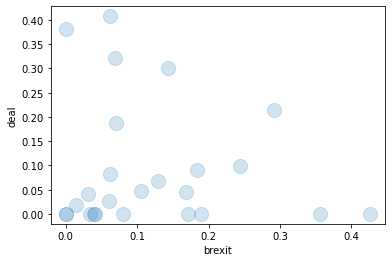

In [34]:
ax = tf_idf_df.plot(kind='scatter', x='brexit', y='deal', alpha=0.2, s=200)
ax.set_xlabel("brexit")
ax.set_ylabel("deal")

#### Cluster the 25 docuemtns about Brexit using K-means clustering

In [35]:
# For details about k-mean, see https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3)
km.fit(matrix)

KMeans(n_clusters=3)

In [36]:
# Assign a document to a category 
tf_idf_df['category'] = km.labels_
tf_idf_df

,accuse,act,add,agree,agreement,allow,announce,argue,ask,attack,...,warn,way,week,withdrawal,word,work,worker,write,year,category
0,0.000000,0.035650,0.028267,0.000000,0.133689,0.031492,0.071301,0.000000,0.056533,0.000000,...,0.029790,0.000000,0.062984,0.035650,0.000000,0.000000,0.000000,0.035650,0.000000,2
1,0.028228,0.141138,0.067143,0.047174,0.052926,0.024935,0.000000,0.000000,0.067143,0.000000,...,0.023587,0.000000,0.074805,0.056455,0.000000,0.000000,0.056455,0.028228,0.019378,0
2,0.000000,0.000000,0.070562,0.074364,0.000000,0.078614,0.000000,0.000000,0.141124,0.078614,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
3,0.000000,0.000000,0.000000,0.052316,0.117391,0.000000,0.000000,0.058696,0.000000,0.055306,...,0.156948,0.000000,0.000000,0.062609,0.000000,0.000000,0.000000,0.000000,0.042981,2
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050301,0.000000,0.039883,0.000000,...,0.000000,0.094314,0.000000,0.000000,0.050301,0.126094,0.100602,0.000000,0.172658,1
5,0.000000,0.000000,0.000000,0.113082,0.126872,0.000000,0.135331,0.000000,0.000000,0.000000,...,0.000000,0.126872,0.000000,0.135331,0.000000,0.000000,0.000000,0.000000,0.000000,2
6,0.000000,0.000000,0.118646,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066093,...,0.000000,0.000000,0.132185,0.000000,0.000000,0.187558,0.000000,0.000000,0.000000,1
7,0.065304,0.000000,0.000000,0.000000,0.061222,0.000000,0.000000,0.061222,0.103556,0.057687,...,0.000000,0.000000,0.000000,0.065304,0.000000,0.000000,0.000000,0.000000,0.000000,2
8,0.000000,0.076787,0.000000,0.128327,0.000000,0.000000,0.000000,0.071988,0.000000,0.067831,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.421718,1
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2


#### Plot the 3 clusters using a scatter plot

Text(0, 0.5, 'deal')

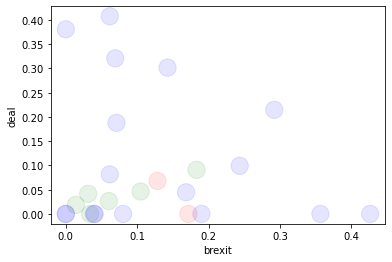

In [37]:
# Specify a color for each category
colormap = {
    0: 'red',
    1: 'green',
    2: 'blue'
}

# Create a color map
colors = tf_idf_df.apply(lambda row: colormap[row.category], axis=1)

# # Plot your scatter plot
ax = tf_idf_df.plot(kind='scatter', x='brexit', y='deal', alpha=0.1, s=300, c=colors)
ax.set_xlabel("brexit")
ax.set_ylabel("deal")

### Cluster the terms `brexit` and `deal` using TF-IDF for the entire corpus  

In [38]:
# Compute TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', 
                             min_df = 0.1, 
                             max_df = 0.9, # threshold depends on corpus and question
                             max_features=100) 
matrix = vectorizer.fit_transform(corpus['tokens'])

# DataFrame
tf_idf_df = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names())
tf_idf_df

,accord,add,allow,ask,big,billion,brexit,build,business,california,...,user,video,want,way,website,week,work,world,write,year
0,0.065904,0.000000,0.000000,0.000000,0.073009,0.088046,0.0,0.000000,0.000000,0.000000,...,0.000000,0.172412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.079559,0.171984,0.000000,0.000000,0.088136,0.106290,0.0,0.000000,0.000000,0.000000,...,0.107447,0.104068,0.000000,0.000000,0.000000,0.000000,0.074522,0.177753,0.000000,0.000000
3,0.040884,0.034369,0.026728,0.026259,0.080517,0.054620,0.0,0.023524,0.024954,0.014896,...,0.000000,0.005942,0.101466,0.014157,0.006658,0.091802,0.029785,0.060895,0.028260,0.214770
4,0.028326,0.153084,0.033334,0.032748,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.030129,0.088280,0.000000,0.000000,0.026533,0.221506,0.035244,0.093982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,0.000000,0.060369,0.000000,0.000000,0.000000,0.000000,0.0,0.072309,0.061363,0.000000,...,0.075431,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062394,0.000000,0.000000
171,0.000000,0.106149,0.115568,0.000000,0.000000,0.131204,0.0,0.000000,0.107898,0.000000,...,0.000000,0.000000,0.104458,0.000000,0.000000,0.000000,0.000000,0.109710,0.000000,0.081459
172,0.000000,0.050041,0.000000,0.000000,0.102578,0.061853,0.0,0.000000,0.101732,0.000000,...,0.062527,0.000000,0.000000,0.096193,0.000000,0.049244,0.043366,0.051720,0.057605,0.192009
173,0.129818,0.140315,0.000000,0.000000,0.000000,0.260152,0.0,0.000000,0.071313,0.000000,...,0.087662,0.000000,0.000000,0.000000,0.000000,0.000000,0.121598,0.000000,0.080761,0.053839


Text(0, 0.5, 'deal')

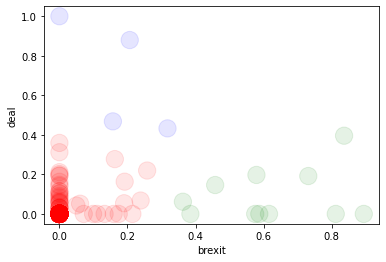

In [39]:
# Cluster with 3 categories
# Use only the terms 'brexit' and 'deal'
km = KMeans(n_clusters=3)
km.fit(tf_idf_df[['brexit', 'deal']])

# Assign the category to the dataframe
tf_idf_df['category'] = km.labels_

# Create a color map
colormap = { 0: 'red', 1: 'green', 2: 'blue' }
colors = tf_idf_df.apply(lambda row: colormap[row.category], axis=1)

# Plot your scatter plot
ax = tf_idf_df.plot(kind='scatter', x='brexit', y='deal', alpha=0.1, s=300, c=colors)
ax.set_xlabel("brexit")
ax.set_ylabel("deal")

## Word Embeddings and word2vec

> You shall know a word by the company it keeps (Firth, 1957).

`Word2vec` [Mikolov et al., 2013](https://arxiv.org/abs/1301.3781) and related techniques (e.g., [GloVe](https://nlp.stanford.edu/projects/glove/)) use the context of a given word — i.e., the words surrounding a word — to learn its meaning and represent it as vectors.

Two word2vec models: Skip-Gram and Continuous Bag of Words (CBOW)

The skip-gram model predicts the probabilities of a word given the context of word or words. For example, in the sentence "UK agrees Brexit trade deal", we have a target word and context words surrounding the target word. The number of words to be considered around the target word is called the window size. Using a window size of 2, here are the first three target and context variables for the sentence "UK agrees Brexit trade deal with EU": 

| Target word | Context word(s) |
|---|--------|
| UK | agree Brexit |
| agree | UK Brexit trade |
| Brexit | UK agree trade deal  |

See Akshay Kulkarni and Adarsha Shivananda. 2019. Natural Language Processing Recipes. [Chapter 3: Converting Text to Features](https://learning.oreilly.com/library/view/natural-language-processing/9781484242674/html/475440_1_En_3_Chapter.xhtml#)

In [40]:
# Convert your tokens in the News dataset into a list
corpus_brexit['tokens']= corpus_brexit['tokens'].apply(lambda token_string: token_string.split('|*|'))

<ipython-input-40-148acfbc1404>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus_brexit['tokens']= corpus_brexit['tokens'].apply(lambda token_string: token_string.split('|*|'))


In [41]:
corpus['tokens']= corpus['tokens'].apply(lambda token_string: token_string.split('|*|'))

In [42]:
corpus['tokens'].head()

index
0    [video, image, satellite, image, insane, view, nsw, fire, space, satellite, image, huge, smoke, billow, number, bushfire, nsw, nsw, fire, space, source, twitter, startling, satellite, image, fire,...
1    [chief_executive, address, press, citywide, chaos, transport, disruption, early, police, shoot, protester, leave, -pron-, intensive, care, separately, man, set, fire, dispute, chaos, continue, sho...
2    [hong_kong, cnn, china, announce, curfew, online, gaming, minor, new, measure, aim, curb, video, game, addiction, official, government, guideline, apply, online, gaming, platform, operate, country...
3    [washington, cnn, president_donald, trump, relentlessly, dishonest, week, scandal, -pron-, dealing, ukraine, false_claim, component, story, trump, false_claim, week, second, high, total, week, -pr...
4    [cnn, bread, -pron-, likely, think, long, -pron-, hungry, slice, sourdough, crave, tortilla, -pron-, imagine, lot, -pron-, bread, easy, picture, -pron-, hard, define, br

In [43]:
# Training the word2vec skip-gram model
skipgram = Word2Vec(corpus['tokens'], size =300, window = 3, min_count=1,sg = 1)


In [44]:
skipgram['brexit']

<ipython-input-44-af6ecfbb24a8>:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  skipgram['brexit']


array([-9.37505066e-02,  6.26151869e-03, -4.28024791e-02, -1.57850370e-01,
       -1.48179740e-01, -1.58858135e-01,  1.46182269e-01, -6.45252392e-02,
        9.63558331e-02,  7.37459362e-02, -9.16519985e-02, -3.14190015e-02,
       -1.12843759e-01,  5.72994240e-02,  1.18678384e-01,  4.81168143e-02,
       -5.27412407e-02, -6.78045303e-02,  3.13664004e-02, -1.79761481e-02,
       -2.68206656e-01,  4.44219485e-02, -3.15881521e-02, -1.70482293e-01,
       -8.67820382e-02,  1.31984159e-01,  4.04684767e-02, -4.56722900e-02,
        1.53556153e-01,  1.56105816e-01,  2.17865612e-02, -1.86245870e-02,
       -6.95032924e-02, -8.95807445e-02, -4.71950546e-02,  6.76501170e-02,
        6.32606298e-02, -4.28809002e-02, -8.26412588e-02,  1.46437362e-01,
       -7.09065422e-03, -5.68576972e-04,  2.82835830e-02, -2.11212113e-02,
        1.96370129e-02, -6.70785233e-02,  1.44918010e-01, -9.09216478e-02,
       -2.80960441e-01,  1.08613051e-01, -1.41447991e-01, -1.30918175e-01,
        6.24949522e-02, -

In [45]:
print("Dimensionality—size of vocabulary and size of vectors:", skipgram)

# access vector for one word, "brexit" in this instance
print("vector for 'brexit':", skipgram['brexit'])

Dimensionality—size of vocabulary and size of vectors: Word2Vec(vocab=10834, size=300, alpha=0.025)
vector for 'brexit': [-9.37505066e-02  6.26151869e-03 -4.28024791e-02 -1.57850370e-01
 -1.48179740e-01 -1.58858135e-01  1.46182269e-01 -6.45252392e-02
  9.63558331e-02  7.37459362e-02 -9.16519985e-02 -3.14190015e-02
 -1.12843759e-01  5.72994240e-02  1.18678384e-01  4.81168143e-02
 -5.27412407e-02 -6.78045303e-02  3.13664004e-02 -1.79761481e-02
 -2.68206656e-01  4.44219485e-02 -3.15881521e-02 -1.70482293e-01
 -8.67820382e-02  1.31984159e-01  4.04684767e-02 -4.56722900e-02
  1.53556153e-01  1.56105816e-01  2.17865612e-02 -1.86245870e-02
 -6.95032924e-02 -8.95807445e-02 -4.71950546e-02  6.76501170e-02
  6.32606298e-02 -4.28809002e-02 -8.26412588e-02  1.46437362e-01
 -7.09065422e-03 -5.68576972e-04  2.82835830e-02 -2.11212113e-02
  1.96370129e-02 -6.70785233e-02  1.44918010e-01 -9.09216478e-02
 -2.80960441e-01  1.08613051e-01 -1.41447991e-01 -1.30918175e-01
  6.24949522e-02 -2.32194275e-01 -

<ipython-input-45-2527db47bd23>:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  print("vector for 'brexit':", skipgram['brexit'])


In [46]:
# Similarity between two tokens, e.g., brexit and deal
skipgram.wv.similarity('brexit', 'deal')

0.99301666

In [47]:
# The most similar token to a given token, e.g., brexit
skipgram.wv.most_similar(positive = "brexit")

[('leave', 0.9997541904449463),
 ('agree', 0.9997530579566956),
 ('sign', 0.9997503757476807),
 ('life', 0.9997472167015076),
 ('anymore', 0.9997442960739136),
 ('lie', 0.9997372031211853),
 ('mother', 0.9997352361679077),
 ('family', 0.9997307062149048),
 ('eu', 0.9997249841690063),
 ('little', 0.9997208118438721)]

<ipython-input-48-d1d78608db6a>:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  data = skipgram[skipgram.wv.vocab]


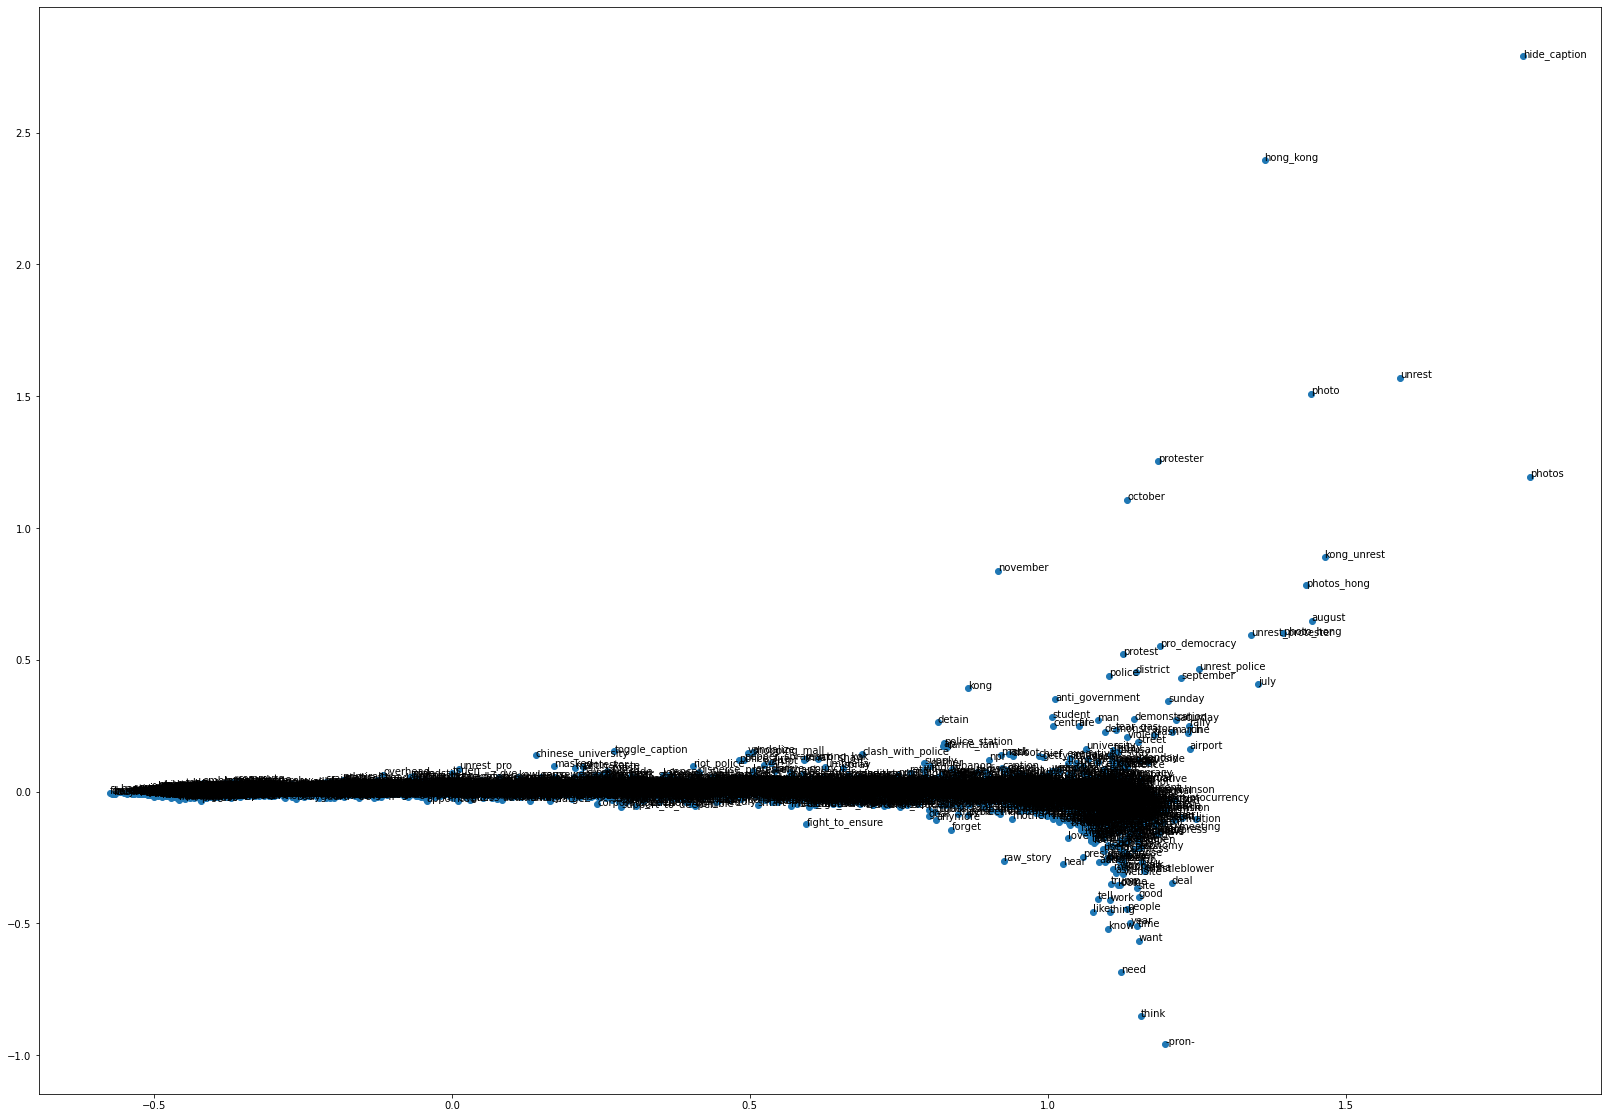

In [48]:
# Fit Principal component analysis (PCA) on the skipgram model output and plot the first 2 components

data = skipgram[skipgram.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(data)
# create a scatter plot of the projection
plt.figure(figsize=(28,20))
plt.scatter(result[:, 0], result[:, 1])
words = list(skipgram.wv.vocab)

for i, word in enumerate(words):
       plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()


#### Use a pre-trained model using Google News data

See the article by Garg etal. 2018 [Word embeddings quantify 100 years of gender and ethnic stereotypes](https://www.pnas.org/content/115/16/E3635) 

In [ ]:
# Load the Word2vec model trained on the Google News dataset 
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

In [ ]:
# Obtain vectors for terms in the model
immigration = wv['immigration']
immigration

In [ ]:
print(wv.most_similar(positive=['immigration'], topn=20))

In [ ]:
# print the 5 most similar words to “nurse” or “librarian”
print(wv.most_similar(positive=['nurse', 'librarian'], topn=20))

In [ ]:
# Compare similarities of pairs of concepts
pairs = [
    ('sociology', 'society'), 
    ('sociology', 'individual'),
    ('sociology', 'market'),
]
for w1, w2 in pairs:
    print('%r\t%r\t%.2f' % (w1, w2, wv.similarity(w1, w2)))

In [ ]:
# Vector relations and word analogies e.g. vector_King - vector_Man = vector_Queen - vector_Woman
wv.most_similar(positive=['king', 'women'], negative=['man'])

In [ ]:
# Another analogy example
wv.most_similar(positive=['Rome', 'France'], negative=['Paris'])

## Different ways of storing and accessing your corpus for Word2Vec training

In [ ]:
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.summarization.textcleaner import split_sentences
import re
import os

In [ ]:
# Save in a variable the path to your directory where you store your text files 
DocByLine = '/Users/valentindanchev/Documents/Teaching/sc207/DocByLine'

If you have a plain-text file or files where each 'document' is on its own line, you can use the class [`MyPreprocessedSentences`](https://rare-technologies.com/word2vec-tutorial/) to process the input file by file, line by line. The class collects documents and processes them using the function `simple_preprocess` from the module `gensim.utils`, which contains various general utility functions. The function converts a document into a list of tokens that are lowercased and de-accented (optional). We use txt files from the Gutenberg project, including the books [Pride and Prejudice](http://www.gutenberg.org/ebooks/1342), [Frankenstein](http://www.gutenberg.org/ebooks/84), and others. 

Parameters of `simple_preprocess`: 

* `doc` This is your input document (str).

* `min_len` Minimum lenght of token in output (inclusive). Shorter tokens are discarded. Default is 2. 

* `max_len` Maximum length of token in output (inclusive). Longer tokens are discarded. Default is 15. 

* `deacc` Remove accent marks from tokens using the deaccent() function. Default is `False`.

Let's add `simple_preprocess` to the `MySentences` class:

In [ ]:
# Define the class MyPreprocessedSentences
class MyPreprocessedSentences(object):
    def __init__(self, dirname):
        self.dirname = dirname
 
    def __iter__(self):
        for fname in os.listdir(self.dirname):
            # specify encoding "cp437" as other encodings, e.g., "utf8" may give you an error
            for line in open(os.path.join(self.dirname, fname), encoding="cp437"):
                yield gensim.utils.simple_preprocess(line, deacc=True) # vocabulary preprocessing 

# Apply MyPreprocessedSentences and fit the vanilla Word2Vec model to the preprocessed sentences
sentences = MyPreprocessedSentences(DocByLine) # a memory-friendly iterator
model = gensim.models.Word2Vec(sentences, min_count=1)

You can view the model vocabulary in the field `vocab` of the Word2Vec model's `wv` property. The vocabulary is stored as a dictionary where each key is a token. 

In [ ]:
# Show the vocabulary of your Word2Vec model
model.wv.vocab

In [ ]:
# Show the size of the vocabulary
len(model.wv.vocab)
# Change the min_len parameter of the simple_preprocess function in the MyPreprocessedSentences class 
# and check again the length of the vocabulary

Sometimes our docuemtns are not neatly organised such that each line in a file is a 'document'. For example, we may have many books each stored as a single file in a directory.

In [ ]:
DocByFile = '/Users/valentindanchev/Documents/Teaching/sc207/DocByFile'

In [ ]:
class FromBooksToSentences(object):
    def __init__(self, dirname):
        self.dirname = dirname

    def __iter__(self):
        for fname in os.listdir(self.dirname):
            #with open(os.path.join(self.dirname, fname), encoding="cp437") as f:
            with open(os.path.join(self.dirname, fname), errors='ignore') as f:
                # Read each file and replace multiple characters at once using nested replace()
                text = f.read().replace('\n', '').replace('”', '').replace('“', '')
                # Use the re module to replace all multiple whitespaces with single whitespace 
                text = re.sub('\s+',' ', text)
                # print(text) # uncomment to see the output
                # Split the text into a list of sentences using the split_sentences function from gensim   
                for sentence in split_sentences(text):
                    print("SENTENCE:",sentence) # uncomment to see the output
                    yield gensim.utils.simple_preprocess(sentence, deacc=True)

In [ ]:
sentences = FromBooksToSentences(DocByFile)
model = gensim.models.Word2Vec(sentences, min_count=4)

In [ ]:
model.wv.vocab

In [ ]:
len(model.wv.vocab)

In [ ]:
model.wv['frankenstein']

In [ ]:
print(model.wv.most_similar(positive=['frankenstein'], topn=10))

## Topic modelling via LDA (Latent Dirichlet allocation)
Topic modelling is a text mininig technique for discovery of general "topics" or themes in a collection of text documents.  

* Each topic is a distribution over words
* Each document is a mixture of corpus-wide topics
* Each word is drawn from one of the topics


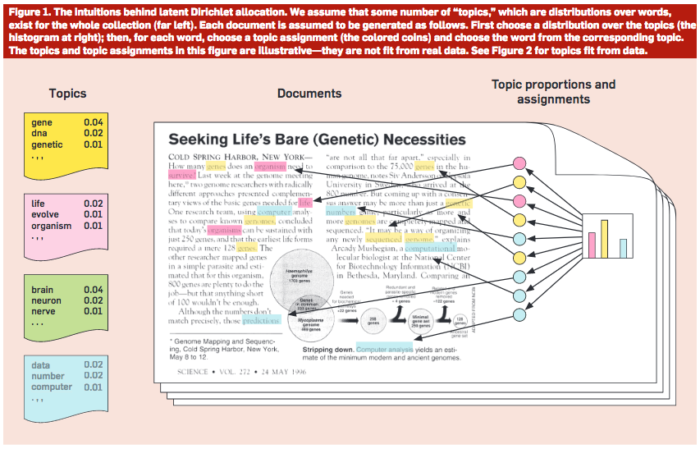

Let's first create a toy dataset 

In [ ]:
# A conveninet sample of sentences about Covid vaccine from BBC, Google's Health Info
doc1 = "The threat of vaccine nationalism"
doc2 = "Vaccine nationalism means that poor countries will be left behind"
doc3 = "Is vaccine nationalism an obstacle or an obligation?"
doc4 = "World Health Organization said vaccine nationalism could prolong the pandemic"
doc5 = "Which vaccine is being used in UK?"
doc6 = "Who should not get Covid vaccine?"
doc7 = "How many injections do you need for the Oxford vaccine?"
doc8 = "Does vaccine stop you getting Covid?"
doc9 = "Who is eligible to get the COVID-19 vaccine"

In [ ]:
docs = [doc1, doc2, doc3, doc4, doc5, doc6, doc7, doc8, doc9]
docs

In [ ]:
# Install and import libraries
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

In [ ]:
# Define a function for cleaning the documents via NLTK—remove stop words, punctuation, and normalise tokens 
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([word for word in doc.lower().split() if word not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

In [ ]:
# Clean the documents
clean_docs = [clean(doc).split() for doc in docs]

In [ ]:
# Importing gensim and the LDA models
import gensim
from gensim import corpora, models
# Creating the term dictionary of our corpus, where every unique term is assigned an index.
dictionary = corpora.Dictionary(clean_docs)
# Use the dictionary created above to convert the documents into document-term matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in clean_docs]
doc_term_matrix

### Running the LDA model

Parameters of the `models.ldamodel.LdaModel` function in `Gensim`
* `corpus` Document-terms matrix.

* `num_topics` The number of requested latent topics to be extracted from the training corpus.

* `id2word` Mapping from word IDs to words (via `gensim.corpora.dictionary.Dictionary`. It is used to determine the vocabulary size and topic printing.

In [ ]:
# LDA model using gensim library
LDAModel = models.ldamodel.LdaModel(doc_term_matrix, num_topics=5, id2word = dictionary, passes=50)

# Resulting topics—show the topic to terms distribution
print(LDAModel.print_topics(num_topics=5, num_words=5))

### Visualising the discovered topics via [pyLDAvis](http://bl.ocks.org/AlessandraSozzi/raw/ce1ace56e4aed6f2d614ae2243aab5a5/)
LDAvis is a web-based interactive visualisation of topics estimated using the LDA model

In [ ]:
import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(topic_model=LDAModel, 
                              corpus=doc_term_matrix, 
                              dictionary=dictionary)
pyLDAvis.show(vis)
# pyLDAvis.enable_notebook()
# pyLDAvis.display(vis)

## Acknowledgements

1. [Converting Text to Features,](https://learning.oreilly.com/library/view/natural-language-processing/9781484242674/html/475440_1_En_3_Chapter.xhtml#) in _Natural Language Processing Recipes_. Akshay Kulkarni & Adarsha Shivananda. 2019.
2. [Sklearn's module on feature extraction](https://scikit-learn.org/stable/modules/feature_extraction.html).
3. [Vector Semantics and Embeddings,](https://web.stanford.edu/~jurafsky/slp3/6.pdf) in _Speech and Language Processing_. Daniel Jurafsky & James H. Martin. Draft of December 30, 2020.
4. [K-Means Clustering with scikit-learn.](http://jonathansoma.com/lede/algorithms-2017/classes/clustering/k-means-clustering-with-scikit-learn/)
5. [Pandas for Everyone.](https://www.pearson.com/us/higher-education/program/Chen-Pandas-for-Everyone-Python-Data-Analysis/PGM335102.html). Daniel Chen. 2018. 